In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
%matplotlib inline

In [2]:
# dataset we train word2vec on
data = pd.read_csv("data/cleaned_financial_tweets.csv")
print(data.head())


                    id                                               text  \
0  1019696670777503700  video i was in my office i was minding my own ...   
1  1019709091038548000  the price of lumber lb f is down @number since...   
2  1019711413798035500           who says the american dream is dead http   
3  1019718460287389700  how satellites avoid attacks and space junk wh...   
4  1019720723441635300  senate wants emergency alerts to go out throug...   

                        timestamp        source symbols      company_names  \
0  Wed Jul 18 21:33:26 +0000 2018  GoldmanSachs      GS  The Goldman Sachs   
1  Wed Jul 18 22:22:47 +0000 2018    StockTwits       M             Macy's   
2  Wed Jul 18 22:32:01 +0000 2018     TheStreet     AIG           American   
3  Wed Jul 18 23:00:01 +0000 2018        Forbes    ORCL             Oracle   
4  Wed Jul 18 23:09:00 +0000 2018    TechCrunch    NFLX            Netflix   

                                                 url  verified  
0  

In [3]:
import pandas as pd
from gensim.models import Word2Vec, KeyedVectors
data = [row.split(' ') for row in data['text']]
model = Word2Vec(data, min_count=3, vector_size=100, workers=3, window=5, sg=1, epochs=100)
word_vectors = model.wv

w1 = "support"
model.wv.most_similar(positive=w1)

[('@numberish', 0.5532045364379883),
 ('bounces', 0.531642496585846),
 ('ris', 0.5205349326133728),
 ('stipend', 0.5196207761764526),
 ('@stockech', 0.5064327716827393),
 ('level', 0.5055236220359802),
 ('flag', 0.49709606170654297),
 ('symmetry', 0.4909267723560333),
 ('fallingwedge', 0.48879274725914),
 ('ibdpartner', 0.484421968460083)]

In [4]:
train_data = pd.read_csv("data/train_data.csv")
test_data = pd.read_csv("data/test_data.csv")

print(train_data.head())

                                                text  label
0              @stock breakout watch @number @number      1
1  @user i hate to be under @number as average i ...     -1
2  nice share @user @stock intraday short explain...     -1
3  @stock still looking interesting trading withi...      1
4          the ticker has actually stopped on @stock      1


In [5]:
from datasets import load_dataset, Dataset

train_data['label'] = train_data['label'].replace(-1,0)
test_data['label'] = test_data['label'].replace(-1,0)
train_df = Dataset.from_pandas(train_data)
test_df = Dataset.from_pandas(test_data)
trainval_df = train_df.train_test_split(test_size=0.2)
trainval_df, test_df
x_train = trainval_df['train']["text"]
x_val = trainval_df['test']['text']
x_test = test_df["text"]
y_train = trainval_df['train']["label"]
y_val = trainval_df['test']['text']
y_test = test_df["label"]

Parameter 'generator'=Generator(PCG64) of the transform datasets.arrow_dataset.Dataset.train_test_split couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
def make_feature_vec(words, model, num_features):
    """
    Average the word vectors for a set of words
    """
    feature_vec = np.zeros((num_features,),dtype="float32")  # pre-initialize (for speed)
    nwords = 0.
    index2word_set = set(model.wv.index_to_key)  # words known to the model

    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            feature_vec = np.add(feature_vec,model.wv[word])
    
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec


def get_avg_feature_vecs(reviews, model, num_features):
    """
    Calculate average feature vectors for all reviews
    """
    counter = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')  # pre-initialize (for speed)
    
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1
    return review_feature_vecs

In [7]:
# calculate average feature vectors for training and test sets
num_features = 100
clean_train_reviews = x_train
# for review in x_train:
#     clean_train_reviews.append(review_to_wordlist(review, remove_stopwords=True))
trainDataVecs = get_avg_feature_vecs(clean_train_reviews, model, num_features)

In [8]:
clean_test_reviews = x_test
# for review in x_test:
#     clean_test_reviews.append(review_to_wordlist(review, remove_stopwords=True))
testDataVecs = get_avg_feature_vecs(clean_test_reviews, model, num_features)

In [9]:
trainDataVecs2 = np.transpose(trainDataVecs)
trainDataVecs.shape

(3705, 100)

In [10]:
# Fit a random forest to the training data before hyperparameter tuning)
forest = RandomForestClassifier()

print("Fitting a random forest to labeled training data...")
forest = forest.fit(trainDataVecs, y_train)

Fitting a random forest to labeled training data...


In [11]:
#Now we'll do some hyperparameter tuning using GridSearchCV.
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [12]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

cv = GridSearchCV(rf,parameters)
cv.fit(trainDataVecs,y_train)
print_results(cv)

BEST PARAMS: {'max_depth': 10, 'n_estimators': 100}

0.632 (+/-0.003) for {'max_depth': 2, 'n_estimators': 5}
0.632 (+/-0.001) for {'max_depth': 2, 'n_estimators': 50}
0.632 (+/-0.001) for {'max_depth': 2, 'n_estimators': 100}
0.631 (+/-0.031) for {'max_depth': 10, 'n_estimators': 5}
0.668 (+/-0.018) for {'max_depth': 10, 'n_estimators': 50}
0.673 (+/-0.023) for {'max_depth': 10, 'n_estimators': 100}
0.627 (+/-0.036) for {'max_depth': 20, 'n_estimators': 5}
0.66 (+/-0.016) for {'max_depth': 20, 'n_estimators': 50}
0.67 (+/-0.016) for {'max_depth': 20, 'n_estimators': 100}
0.615 (+/-0.041) for {'max_depth': None, 'n_estimators': 5}
0.655 (+/-0.03) for {'max_depth': None, 'n_estimators': 50}
0.666 (+/-0.018) for {'max_depth': None, 'n_estimators': 100}


In [13]:
#using the best parameter, we train a new random forest rf2 

rf2 = RandomForestClassifier(n_estimators = 100, max_depth = 20)
rf2.fit(trainDataVecs, y_train)

RandomForestClassifier(max_depth=20)

In [14]:
# remove instances in test set that could not be represented as feature vectors
nan_indices = list({x for x,y in np.argwhere(np.isnan(testDataVecs))})
if len(nan_indices) > 0:
    print('Removing {:d} instances from test set.'.format(len(nan_indices)))
    testDataVecs = np.delete(testDataVecs, nan_indices, axis=0)
    x_test.drop(x_test.iloc[nan_indices, :].index, axis=0, inplace=True)
    assert testDataVecs.shape[0] == len(x_test)

In [15]:
print("Predicting labels for test data..")
result = forest.predict(testDataVecs)

Predicting labels for test data..


In [16]:
print("Predicting labels for test data..")
predictions = rf2.predict(testDataVecs)

Predicting labels for test data..


In [17]:
print(classification_report(y_test, result))
accuracy = round(accuracy_score(y_test, result),3)
print(accuracy)

              precision    recall  f1-score   support

           0       0.61      0.32      0.42       396
           1       0.72      0.90      0.80       763

    accuracy                           0.70      1159
   macro avg       0.66      0.61      0.61      1159
weighted avg       0.68      0.70      0.67      1159

0.698


In [18]:
print(classification_report(y_test, predictions))
accuracy1 = round(accuracy_score(y_test, predictions), 3)
print(accuracy1)

              precision    recall  f1-score   support

           0       0.60      0.28      0.38       396
           1       0.71      0.90      0.79       763

    accuracy                           0.69      1159
   macro avg       0.65      0.59      0.59      1159
weighted avg       0.67      0.69      0.65      1159

0.69


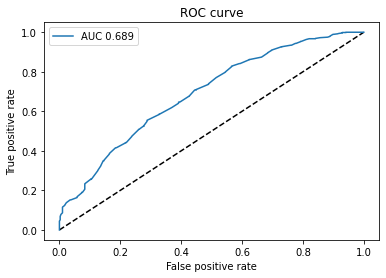

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
probs = forest.predict_proba(testDataVecs)[:, 1]

fpr, tpr, _ = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

<AxesSubplot:>

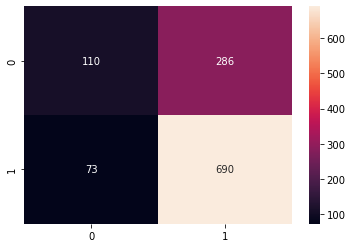

In [20]:
sns.heatmap(confusion_matrix(y_test,predictions),annot=True,fmt='.0f')